In [1]:
import sys 
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN import network, activation_functions, loss_functions
from NN import ANN


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Simple Run Checks
To identify if there is no code broken

In [2]:
from importlib import reload
reload(network)
I = np.array([[0.05, 0.10]])
W = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.35, label="H1")
netH, outH =  h1.feed_forward(I)
print(netH)
print(outH)

[[0.3775 0.3925]]
[[0.59326999 0.59688438]]


In [3]:
from importlib import reload
reload(network)
I = np.array([[0.59326999, 0.59688438]])
W = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o1 = network.Layer(2, 2, 'sigmoid', weights=W, bias=0.6, label="H1")
netO, outO =  o1.feed_forward(I)
print(netO)
print(outO)

[[1.10590597 1.2249214 ]]
[[0.75136507 0.77292847]]


# Convergence Checkings
Based on the sample given by the class teacher

## Manual Calculations

In [4]:
from importlib import reload
reload(network)
model = network.NN(loss='smd')
X = np.array([[0.05, 0.10]])

Wh = np.array([[0.15, 0.2], [0.25, 0.3]]).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]]).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
model.add_layer(h)
model.add_layer(o)
model.show_weights()

Y, aY = model.feed_forward(X)
Y_, aY_ = ([1.10590597, 1.2249214 ], [0.75136507, 0.77292847])
print("Y\n",Y_)
print("\na(Y)\n",aY_)

assert((Y - Y_).sum() < np.finfo(np.float32).eps)
assert((aY - aY_).sum() < np.finfo(np.float32).eps)


Y
 [1.10590597, 1.2249214]

a(Y)
 [0.75136507, 0.77292847]


### Working on the back propagation

In [5]:
from importlib import reload
reload(network)
model.show_weights()
Y = np.array([0.01, 0.99])
Etotal = loss_functions.smd(aY, Y)
print(Etotal)
assert((Etotal - 0.2983711) < np.finfo(np.float32).eps)

0.2983711087600027


### Emulating the weights update for the layer O 

In [6]:
reload(loss_functions)
reload(activation_functions)
lr = 0.5
#Done - Partial
dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
print(dEo_dw)

# Done
dOuto_Dneto = activation_functions.sigmoid_derivative_chain(outO)
print('dout',dOuto_Dneto)

# Done - Self.input
dNeto  = outH
print('dnet',dNeto) 
# Done
deltaO  = dEo_dw * dOuto_Dneto
print('delta', deltaO)

dWO = deltaO * outH
print('dw', dWO)
# Done
updateO = Wo - lr * dWO
print('update', updateO)

[[ 0.74136507 -0.21707153]]
dout [[0.1868156  0.17551005]]
dnet [[0.59326999 0.59688438]]
delta [[ 0.13849856 -0.03809824]]
dw [[ 0.08216704 -0.02274024]]
update [[0.35891648 0.51137012]
 [0.40891648 0.56137012]]


In [7]:
#
# Done - Partial
dEo_dOh = deltaO * Wo
dETotal_dOh = dEo_dOh.sum(axis=1)
print (dEo_dOh)
print('dETotal_dOh', dETotal_dOh)

# Done
dOuth_Dneth = activation_functions.sigmoid_derivative_chain(outH)
print('dOuth_Dneth', dOuth_Dneth)


# Done
deltaH = dETotal_dOh * dOuth_Dneth 
print('deltaH', deltaH)

# done
# self.input
dNeth_dw = X
dWh = deltaH * dNeth_dw
print('dWh', dWh)

# Done
updateH = Wh - lr * dWh
print('update', updateH)

[[ 0.05539942 -0.01904912]
 [ 0.06232435 -0.02095403]]
dETotal_dOh [0.03635031 0.04137032]
dOuth_Dneth [[0.24130071 0.24061342]]
deltaH [[0.00877135 0.00995425]]
dWh [[0.00043857 0.00099543]]
update [[0.14978072 0.24950229]
 [0.19978072 0.29950229]]


## Using the implemented Grad calculation for Layers

In [8]:
reload(loss_functions)
reload(activation_functions)
reload(network)
network.DEBUG = False

X = np.array([[0.05, 0.10]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
Y = np.array([0.01, 0.99], np.float64)

for i in range(10000):
    netH, outH = h.feed_forward(X)
    netO, outO = o.feed_forward(outH)

    
    Etotal = loss_functions.smd(outO, Y)
    if (i % 1000) == 0:
        print(i, 'error', Etotal)
    
    dEo_dw = loss_functions.smd_derivative_chain(outO, Y)
    network.dprint(dEo_dw)
    network.dprint ("")
    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer O")
    network.dprint ("==========================================")
    o.backpropagate(dETotal_dOut=dEo_dw)
    network.dprint ("==========================================")
    network.dprint ("")

    network.dprint ("==========================================")
    network.dprint ("Back Propagate Layer H")
    network.dprint ("==========================================")
    h.backpropagate(output_layer=o)
    network.dprint ("==========================================")

print (outO)

0 error 0.2983711087600027
1000 error 0.001114349453733746
2000 error 0.00044486770391326887
3000 error 0.00025152360241099405
4000 error 0.00016427727363225536
5000 error 0.00011622569943793622
6000 error 8.653979465934606e-05
7000 error 6.676957838285888e-05
8000 error 5.288555201099971e-05
9000 error 4.2742284255545085e-05
[[0.01591419 0.98406371]]


# Using the Fit Methods with the full network calculation

## SMD as the Loss Function

In [9]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.00001

X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='smd')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.5, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.01027066 lr: 0.500000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.00054305 lr: 0.500000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.00025539 lr: 0.500000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.00015284 lr: 0.500000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.00010231 lr: 0.500000 
It: 12000 Batch: 1 Epoch 11999 Error: 0.00007315 lr: 0.500000 
It: 14000 Batch: 1 Epoch 13999 Error: 0.00005464 lr: 0.500000 
It: 16000 Batch: 1 Epoch 15999 Error: 0.00004211 lr: 0.500000 
It: 18000 Batch: 1 Epoch 17999 Error: 0.00003323 lr: 0.500000 
It: 20000 Batch: 1 Epoch 19999 Error: 0.00002670 lr: 0.500000 
It: 22000 Batch: 1 Epoch 21999 Error: 0.00002177 lr: 0.500000 
It: 24000 Batch: 1 Epoch 23999 Error: 0.00001797 lr: 0.500000 
It: 26000 Batch: 1 Epoch 25999 Error: 0.00001498 lr: 0.500000 
It: 28000 Batch: 1 Epoch 27999 Error: 0.00001259 lr: 0.500000 
It: 30000 Batch: 1 Epoch 29999 Error: 0.00001066 lr: 0.500000 
Finished 
 It: 30001 Batch: 1 Epoch 30000 Train Loss: 0

## Cross Entropy 

In [10]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.0001
X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 3, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]], np.float64).T
o = network.Layer(3, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.1, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.01)

Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.44643445 lr: 0.100000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.19864310 lr: 0.100000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.16640629 lr: 0.100000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.15169125 lr: 0.100000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.14308035 lr: 0.100000 
It: 12000 Batch: 1 Epoch 11999 Error: 0.13738293 lr: 0.100000 
It: 14000 Batch: 1 Epoch 13999 Error: 0.13332083 lr: 0.100000 
It: 16000 Batch: 1 Epoch 15999 Error: 0.13027448 lr: 0.100000 
It: 18000 Batch: 1 Epoch 17999 Error: 0.12790469 lr: 0.100000 
It: 20000 Batch: 1 Epoch 19999 Error: 0.12600928 lr: 0.100000 
It: 22000 Batch: 1 Epoch 21999 Error: 0.12445982 lr: 0.100000 
It: 24000 Batch: 1 Epoch 23999 Error: 0.12317068 lr: 0.100000 
It: 26000 Batch: 1 Epoch 25999 Error: 0.12208243 lr: 0.100000 
It: 28000 Batch: 1 Epoch 27999 Error: 0.12115250 lr: 0.100000 
It: 30000 Batch: 1 Epoch 29999 Error: 0.12034958 lr: 0.100000 
It: 32000 Batch: 1 Epoch 31999 Error: 0.11965011 lr: 0.

In [11]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False

eps = np.finfo(np.float32).eps

X = np.array([[0.05, 0.10], [0.05, 0.10], [0.10, 0.05]], np.float64)
Y = np.array([[0.0, 1], [0.0, 1], [1., 0.]], np.float64)

h1 = network.Layer(2, 10, 'sigmoid',  label="H1")
h2 = network.Layer(10, 10, 'sigmoid',   label="H2")
o = network.Layer(10, 2, 'sigmoid',  label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=50000, 
          lr=0.1, epsilon=eps,
          print_interval=2000)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()
print(mae)
print(Y, Y_)
assert(mae < 0.1)

Shuffled
It: 2000 Batch: 2 Epoch 666 Error: 1.47487974 lr: 0.100000 
It: 4000 Batch: 1 Epoch 1333 Error: 1.26985269 lr: 0.100000 
It: 6000 Batch: 3 Epoch 1999 Error: 1.25810062 lr: 0.100000 
It: 8000 Batch: 2 Epoch 2666 Error: 1.23560985 lr: 0.100000 
It: 10000 Batch: 1 Epoch 3333 Error: 1.18780812 lr: 0.100000 
It: 12000 Batch: 3 Epoch 3999 Error: 1.09188121 lr: 0.100000 
It: 14000 Batch: 2 Epoch 4666 Error: 0.92185604 lr: 0.100000 
It: 16000 Batch: 1 Epoch 5333 Error: 0.69838649 lr: 0.100000 
It: 18000 Batch: 3 Epoch 5999 Error: 0.50044493 lr: 0.100000 
It: 20000 Batch: 2 Epoch 6666 Error: 0.36877750 lr: 0.100000 
It: 22000 Batch: 1 Epoch 7333 Error: 0.28783146 lr: 0.100000 
It: 24000 Batch: 3 Epoch 7999 Error: 0.23609287 lr: 0.100000 
It: 26000 Batch: 2 Epoch 8666 Error: 0.20096622 lr: 0.100000 
It: 28000 Batch: 1 Epoch 9333 Error: 0.17586544 lr: 0.100000 
It: 30000 Batch: 3 Epoch 9999 Error: 0.15700621 lr: 0.100000 
It: 32000 Batch: 2 Epoch 10666 Error: 0.14231364 lr: 0.100000 
It:

## Multi class Classification Test

In [12]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]
indices_to_one_hot(np.array([1,2,3,0]), 4)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [13]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

nclasses = 5
nsamples = 60000
nfeatures = 60
eps = np.finfo(np.float32).eps
X,  X_val, Y, Y_val = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)

Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

eps = 0.9
lr = 1.
max_iter = 50 * X.shape[0]
print_interval = 10 * 1000

network.DEBUG = False

eps = np.finfo(np.float32).eps

h1 = network.Layer(nfeatures, 32, 'sigmoid', label="H1")
h2 = network.Layer(32, 32, 'sigmoid', label="H2")
h3 = network.Layer(32, 24, 'sigmoid', label="H3")
o = network.Layer(24, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(h2)
model.add_layer(h3)
model.add_layer(o)
model.show_weights()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps,
          decay_iteractions=100 * 1000, decay_rate = 0.9,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1).flatten()
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))
iteraction_log = network.get_iteration_log()


Shuffled
It: 10000 Batch: 10000 Epoch 0 Train Loss: 40.20647355 lr: 1.000000 Val Loss: 30.27153668
It: 20000 Batch: 20000 Epoch 0 Train Loss: 22.84783424 lr: 1.000000 Val Loss: 13.88838187
It: 30000 Batch: 30000 Epoch 0 Train Loss: 10.43027659 lr: 1.000000 Val Loss: 3.02323887
It: 40000 Batch: 40000 Epoch 0 Train Loss: 3.32730969 lr: 1.000000 Val Loss: 3.38164373
It: 50000 Batch: 2000 Epoch 1 Train Loss: 3.33487868 lr: 1.000000 Val Loss: 3.08500476
It: 60000 Batch: 12000 Epoch 1 Train Loss: 3.34072132 lr: 1.000000 Val Loss: 3.00922680
It: 70000 Batch: 22000 Epoch 1 Train Loss: 3.34736500 lr: 1.000000 Val Loss: 3.00397597
It: 80000 Batch: 32000 Epoch 1 Train Loss: 3.33792257 lr: 1.000000 Val Loss: 2.99202411
It: 90000 Batch: 42000 Epoch 1 Train Loss: 3.32792052 lr: 1.000000 Val Loss: 2.98065422
It: 100000 Batch: 4000 Epoch 2 Train Loss: 3.33397672 lr: 1.000000 Val Loss: 3.01132207
It: 110000 Batch: 14000 Epoch 2 Train Loss: 3.22460654 lr: 0.900000 Val Loss: 2.85666945
It: 120000 Batch:

It: 930000 Batch: 18000 Epoch 19 Train Loss: 2.17804419 lr: 0.387420 Val Loss: 2.00945369
It: 940000 Batch: 28000 Epoch 19 Train Loss: 2.21719249 lr: 0.387420 Val Loss: 2.70246351
It: 950000 Batch: 38000 Epoch 19 Train Loss: 2.39806406 lr: 0.387420 Val Loss: 2.32285805
It: 960000 Batch: 48000 Epoch 19 Train Loss: 2.41335571 lr: 0.387420 Val Loss: 2.23126877
It: 970000 Batch: 10000 Epoch 20 Train Loss: 2.50392399 lr: 0.387420 Val Loss: 2.55874761
It: 980000 Batch: 20000 Epoch 20 Train Loss: 2.38888535 lr: 0.387420 Val Loss: 2.03826922
It: 990000 Batch: 30000 Epoch 20 Train Loss: 2.44266710 lr: 0.387420 Val Loss: 2.13380753
It: 1000000 Batch: 40000 Epoch 20 Train Loss: 2.43213033 lr: 0.387420 Val Loss: 2.67651794
It: 1010000 Batch: 2000 Epoch 21 Train Loss: 2.54140067 lr: 0.348678 Val Loss: 2.58258720
It: 1020000 Batch: 12000 Epoch 21 Train Loss: 2.61627008 lr: 0.348678 Val Loss: 2.84162014
It: 1030000 Batch: 22000 Epoch 21 Train Loss: 2.39764644 lr: 0.348678 Val Loss: 2.19364585
It: 104

It: 1840000 Batch: 16000 Epoch 38 Train Loss: 1.12616907 lr: 0.150095 Val Loss: 1.13479352
It: 1850000 Batch: 26000 Epoch 38 Train Loss: 1.08673498 lr: 0.150095 Val Loss: 1.20094218
It: 1860000 Batch: 36000 Epoch 38 Train Loss: 1.07912235 lr: 0.150095 Val Loss: 1.19067149
It: 1870000 Batch: 46000 Epoch 38 Train Loss: 1.18522899 lr: 0.150095 Val Loss: 1.12701329
It: 1880000 Batch: 8000 Epoch 39 Train Loss: 1.07288725 lr: 0.150095 Val Loss: 1.23877617
It: 1890000 Batch: 18000 Epoch 39 Train Loss: 1.12684435 lr: 0.150095 Val Loss: 1.16811470
It: 1900000 Batch: 28000 Epoch 39 Train Loss: 1.09469142 lr: 0.150095 Val Loss: 1.05445552
It: 1910000 Batch: 38000 Epoch 39 Train Loss: 1.08483514 lr: 0.135085 Val Loss: 1.09603895
It: 1920000 Batch: 48000 Epoch 39 Train Loss: 1.08502744 lr: 0.135085 Val Loss: 1.20335597
It: 1930000 Batch: 10000 Epoch 40 Train Loss: 1.11070446 lr: 0.135085 Val Loss: 1.22144701
It: 1940000 Batch: 20000 Epoch 40 Train Loss: 1.05451783 lr: 0.135085 Val Loss: 1.16373835


Validation Stats...
Accuracy: 0.847
Precision: 0.851
Recall: 0.847
F1 Score: 0.848730
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Confusion matrix, without normalization
Normalized confusion matrix


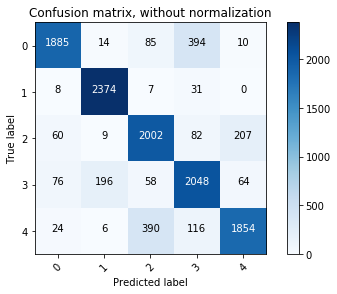

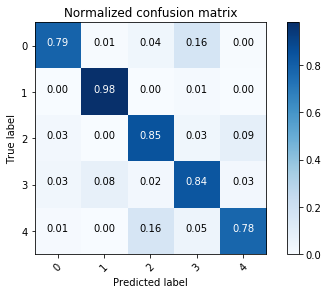

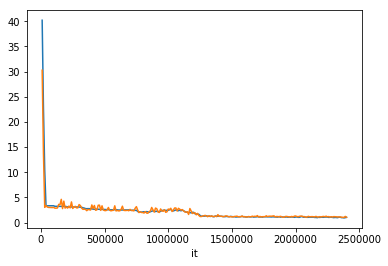

In [14]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()